<a href="https://colab.research.google.com/github/Bkoder/VIMS-IAARC/blob/main/Model_for_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 7.9 MB/s 


In [ ]:
import torch
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
import glob as glob 
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import albumentations as A
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from tqdm import tqdm
import shutil

In [ ]:
print(torch.__version__)

1.11.0+cu113


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# learning parameters
epochs = 300
batch_size = 32

In [ ]:
import torch.nn as nn
import torch


class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.
    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.
    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.
    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.
    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.
    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.
    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class Lanenet(nn.Module):
    def __init__(self, binary_seg=4, embedding_dim=23, encoder_relu=False, decoder_relu=True):
        super(Lanenet, self).__init__()

        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        #embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_notfinal_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits

## <u>Dataset and DataLoader</u>

In [ ]:
paths = os.listdir('/content/drive/Shareddrives/hackathon/Training datasets only/masks')

In [ ]:
paths

['.ipynb_checkpoints', 'wire', 'pvc', 'Bricks', 'Cementitious Debris', 'Rebar']

In [ ]:
wire = glob.glob('/content/drive/Shareddrives/hackathon/Training datasets only/masks/wire/*.png')
pvc = glob.glob('/content/drive/Shareddrives/hackathon/Training datasets only/masks/pvc/*.png')
rebar = glob.glob('/content/drive/Shareddrives/hackathon/Training datasets only/masks/Rebar/*.jpg')
cd = glob.glob('/content/drive/Shareddrives/hackathon/Training datasets only/masks/Cementitious Debris/*.png')
brick = glob.glob('/content/drive/Shareddrives/hackathon/Training datasets only/masks/Bricks/*.png')

In [ ]:
all_paths = wire + pvc + rebar + cd + brick

In [ ]:
import random
random.shuffle(all_paths)

In [ ]:
updated_paths = []   
for i in all_paths:
    try:
        mask_path = i
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        listt = mask_path.split('/')

        name = listt[-1]
        class_id = listt[-2]
        print(name, class_id)

        if class_id == 'Bricks':
            img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/Brick/TRAINING/'+name)

        elif class_id == 'pvc':
            img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/PVC/TRAINING/'+name)

        elif class_id == 'wires':
            img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/Wires/TRAINING/'+name)

        elif class_id == 'Cementitious Debris':
            img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/Cementitious Debris/TRAINING/'+name)

        elif class_id == 'Rebar':
            img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/Rebar/TRAINING/'+name)
        print(mask.shape, img.shape)

        updated_paths.append(mask_path)

    except:
        os.remove(mask_path)

1653077036(1).jpg Rebar
(420, 600, 3) (420, 600, 3)
184.png Bricks
(100, 100, 3) (100, 100, 3)
1653077000(1).jpg Rebar
(1165, 1600, 3) (1165, 1600, 3)
189.png Bricks
(100, 100, 3) (100, 100, 3)
191.png Bricks
(100, 100, 3) (100, 100, 3)
1653077131(1).jpg Rebar
(407, 612, 3) (407, 612, 3)
1653077356(1).jpg Rebar
(280, 390, 3) (280, 390, 3)
110.png pvc
(256, 256, 3) (256, 256, 3)
252374746.jpg Rebar
(1620, 1000, 3) (1620, 1000, 3)
202.png Bricks
(100, 100, 3) (100, 100, 3)
21.png pvc
(256, 256, 3) (256, 256, 3)
1653076984(1).jpg Rebar
(532, 800, 3) (532, 800, 3)
574778a509584.image.jpg Rebar
(500, 783, 3) (500, 783, 3)
197.png Bricks
(100, 100, 3) (100, 100, 3)
1653077575(1).jpg Rebar
(280, 526, 3) (280, 526, 3)
29.png pvc
(256, 256, 3) (256, 256, 3)
test_18.png wire
(256, 256, 3) (256, 256, 3)
1653077171.jpg Rebar
(956, 1300, 3) (956, 1300, 3)
208.png Bricks
(100, 100, 3) (100, 100, 3)
28.png pvc
(256, 256, 3) (256, 256, 3)
195.png Bricks
(100, 100, 3) (100, 100, 3)
136.png Bricks
(256,

In [ ]:
updated_paths

['/content/drive/Shareddrives/hackathon/Training datasets only/masks/Rebar/1653077036(1).jpg',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/Bricks/184.png',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/Rebar/1653077000(1).jpg',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/Bricks/189.png',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/Bricks/191.png',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/Rebar/1653077131(1).jpg',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/Rebar/1653077356(1).jpg',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/pvc/110.png',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/Rebar/252374746.jpg',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/Bricks/202.png',
 '/content/drive/Shareddrives/hackathon/Training datasets only/masks/pvc/21.png',
 '/content/drive/Sha

In [ ]:
color_dict = {
    0: (0, 0, 0), # background
    1:(255, 25, 122), #bricks
    2:(225, 187, 100), #pvc
    3:(89, 100, 6), # wires
    }


def onehot_to_rgb(onehot, colormap = color_dict):
    single_layer = onehot.argmax(-1)
    output = np.zeros(onehot.shape[:2]+(3,))
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

def rgb_to_onehot(rgb_arr, color_dict = color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros(shape, dtype=np.float32)
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

aug = A.Compose([      
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.4),
    A.ElasticTransform(alpha=30, sigma=120 * 0.025, alpha_affine=120 * 0.025, p=0.5),
    A.CLAHE(p=0.5),
    A.RandomBrightnessContrast(p=0.4),        
    A.RandomRotate90(p=0.3),
    A.GridDistortion(p=0.4)
    ])

class CoNSePDataset(Dataset):
  def __init__(self, paths, a = True):

    self.data = paths
    self.a = a
    self.transform = aug
    

  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):

    mask_path = self.data[index]
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (256, 256))

    listt = mask_path.split('/')

    name = listt[-1]
    class_id = listt[-2]



    if class_id == 'Bricks':
        img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/Brick/TRAINING/'+name)

    elif class_id == 'pvc':
        img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/PVC/TRAINING/'+name)

    elif class_id == 'wire':
        img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/Wires/TRAINING/'+name)

    elif class_id == 'Cementitious Debris':
        img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/Cementitious Debris/TRAINING/'+name)

    elif class_id == 'Rebar':
        img = cv2.imread('/content/drive/Shareddrives/hackathon/Training datasets only/Rebar/TRAINING/'+name)

    img = cv2.resize(img, (256, 256))

    if self.a:
        augment = self.transform(image = img, mask=mask)
        image = augment['image']
        mask = augment['mask']

    if not self.a:
        image = img

    image = image.astype(np.float32)
    image = image/255.0
    image = np.transpose(image, (2, 0, 1))


    mask = mask.astype(np.float32)
    mask = mask[:,:, 0:1] / 255.0
    mask = mask.astype(np.float32)

    mask = np.transpose(mask, (2, 0, 1))

    return image, mask




In [ ]:
_train = updated_paths[:-20]
_test = updated_paths[-20:]

In [ ]:
train_ds = CoNSePDataset(
        _train,
        a = True,
    )


train_data_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

test_ds = CoNSePDataset(
        _test,
        a = False,
    )

test_data_loader = DataLoader(test_ds, batch_size=16, shuffle=False)


In [ ]:
os.path.exists('/content/drive/Shareddrives/hackathon/Training datasets only/Brick/TRAINING/13.png')

True

In [ ]:
for i, data in enumerate(test_data_loader):
    x = data[0]
    y = data[1].numpy()
    # e = data[2]
    print(y.shape, x.shape)
    
    break

(16, 1, 256, 256) torch.Size([16, 3, 256, 256])


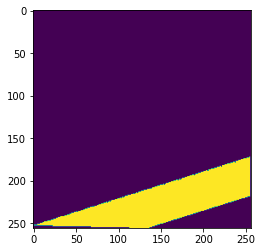

In [ ]:
plt.imshow(y[2][0,:,:])

## <u>Optimizer and Loss Function</u>

In [ ]:
class BinaryDiceLoss(nn.Module):

    def __init__(self, ignore_index=None, reduction='mean',**kwargs):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = 1   # suggest set a large number when target area is large,like '10|100'
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.batch_dice = False # treat a large map when True
        if 'batch_loss' in kwargs.keys():
            self.batch_dice = kwargs['batch_loss']

    def forward(self, output, target, use_sigmoid=True):
        assert output.shape[0] == target.shape[0], f"output & target batch size don't match {output.shape[0]} {target.shape[0]} "
        if use_sigmoid:
            output = nn.Sigmoid()(output)

        if self.ignore_index is not None:
            validmask = (target != self.ignore_index).float()
            output = output.mul(validmask)  # can not use inplace for bp
            target = target.float().mul(validmask)

        dim0= output.shape[0]
        if self.batch_dice:
            dim0 = 1

        output = output.contiguous().view(dim0, -1)
        target = target.contiguous().view(dim0, -1).float()

        num = 2 * torch.sum(torch.mul(output, target), dim=1) + self.smooth
        den = torch.sum(output.abs() + target.abs(), dim=1) + self.smooth

        BCE = F.binary_cross_entropy(output, target, reduction='mean')

        loss = (1 - (num / den))

        if self.reduction == 'mean':
            return loss.mean() + BCE
        elif self.reduction == 'sum':
            return loss.sum() + BCE
        elif self.reduction == 'none':
            return loss + BCE
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

In [ ]:
class FocalLoss_Ori(nn.Module):
    """
    This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
    'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'
        Focal_Loss= -1*alpha*(1-pt)*log(pt)
    :param num_class:
    :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
    :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
                    focus on hard misclassified example
    :param smooth: (float,double) smooth value when cross entropy
    :param size_average: (bool, optional) By default, the losses are averaged over each loss element in the batch.
    """

    def __init__(self, num_class, alpha= [0.4, 0.3, 0.1, 0.1, 0.1], gamma=2, balance_index=-1, size_average=True):
        super(FocalLoss_Ori, self).__init__()
        self.num_class = num_class
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average
        self.eps = 1e-6

        if isinstance(self.alpha, (list, tuple)):
            assert len(self.alpha) == self.num_class
            self.alpha = torch.Tensor(list(self.alpha))
        elif isinstance(self.alpha, (float, int)):
            assert 0 < self.alpha < 1.0, 'alpha should be in `(0,1)`)'
            assert balance_index > -1
            alpha = torch.ones((self.num_class))
            alpha *= 1 - self.alpha
            alpha[balance_index] = self.alpha
            self.alpha = alpha
        elif isinstance(self.alpha, torch.Tensor):
            self.alpha = self.alpha
        else:
            raise TypeError('Not support alpha type, expect `int|float|list|tuple|torch.Tensor`')

    def forward(self, logit, target):

        logit = nn.Sigmoid()(logit)
        target = target.argmax(1)
        if logit.dim() > 2:
            # N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            logit = logit.view(logit.size(0), logit.size(1), -1)
            logit = logit.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            logit = logit.view(-1, logit.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]
        target = target.view(-1, 1)  # [N,d1,d2,...]->[N*d1*d2*...,1]
        pt = logit.gather(1, target).view(-1) + self.eps  # avoid apply
        logpt = pt.log()

        if self.alpha.device != logpt.device:
            alpha = self.alpha.to(logpt.device)
            alpha_class = alpha.gather(0, target.view(-1))
            logpt = alpha_class * logpt
        loss = -1 * torch.pow(torch.sub(1.0, pt), self.gamma) * logpt

        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.Sigmoid()(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [ ]:
class Dice(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.Sigmoid()(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        
        return dice.detach().cpu()

In [ ]:

num_classes = 1
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = Lanenet(num_classes).cuda()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# # criterion
# checkpoint = torch.load('/content/drive/Shareddrives/Classification/NewPanNuke/pannuke_pytorch_deeplabv3P.pth')

# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])

criterion =  BinaryDiceLoss().to(device)
# criterion2 = FocalLoss_Ori(num_class=5).to(device)

matrice = Dice()

## <u>Train and Validation Functions</u>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# training function
from tqdm import tqdm
def fit(epoch, model, dataloader, val_loader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    dice = []
    for i, data in tqdm(enumerate(dataloader)):
        counter += 1
        data, target1 = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()

        outputs = model(data)
       
        loss = criterion(outputs, target1)


        train_running_loss += loss.item()
        d = matrice(outputs, target1).item()
        dice.append(d)
        
        loss.backward()
        optimizer.step()
    

    print('Epoch loss: ', train_running_loss)
    print('Dise: ',sum(dice)/len(dice))

    
    print('-'*10 +"Validation" + "-"*10)
    
    model.eval()
    dise = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):
            x = data[0].cuda()
            y = data[1].cuda()
            pred = model(x)
            d = matrice(pred, y).item()
            dise.append(d)

    print("Epoch:{} Val Dise: ".format(epoch),(sum(dise) / len(dise)))
    return train_running_loss

In [ ]:
if __name__ == '__main__':
    train_ds = CoNSePDataset(
            _train,
            a = True,
        )


    train_data_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

    test_ds = CoNSePDataset(
            _test,
            a = False,
        )

    test_data_loader = DataLoader(test_ds, batch_size=16, shuffle=False)


    train_accuracy = []
    epochs = 400
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} of 400")
        train_epoch_acc = fit(epoch, model, train_data_loader, test_data_loader)
        train_accuracy.append(train_epoch_acc)

        if (epoch+1) % 10 == 0:
            state = {'epoch': epoch, 'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}
            torch.save(state, 'datathon.pth')


Epoch 1 of 400
Training


8it [00:03,  2.16it/s]


Epoch loss:  14.489333391189575
Dise:  0.24846262112259865
----------Validation----------


2it [00:00, 10.61it/s]


Epoch:0 Val Dise:  0.27651672065258026
Epoch 2 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  14.344828724861145
Dise:  0.23829257115721703
----------Validation----------


2it [00:00, 11.03it/s]


Epoch:1 Val Dise:  0.2771688476204872
Epoch 3 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  14.356391429901123
Dise:  0.22722640074789524
----------Validation----------


2it [00:00, 11.03it/s]


Epoch:2 Val Dise:  0.2772527188062668
Epoch 4 of 400
Training


8it [00:03,  2.46it/s]


Epoch loss:  14.071364521980286
Dise:  0.22583318315446377
----------Validation----------


2it [00:00, 10.76it/s]


Epoch:3 Val Dise:  0.27758777141571045
Epoch 5 of 400
Training


8it [00:03,  2.20it/s]


Epoch loss:  13.778282880783081
Dise:  0.2398330681025982
----------Validation----------


2it [00:00, 11.04it/s]


Epoch:4 Val Dise:  0.27792973816394806
Epoch 6 of 400
Training


8it [00:03,  2.20it/s]


Epoch loss:  13.572062253952026
Dise:  0.2355593591928482
----------Validation----------


2it [00:00, 11.29it/s]


Epoch:5 Val Dise:  0.2775261774659157
Epoch 7 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  13.389495372772217
Dise:  0.22761582769453526
----------Validation----------


2it [00:00, 10.62it/s]


Epoch:6 Val Dise:  0.27706071734428406
Epoch 8 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  13.246768474578857
Dise:  0.2251734547317028
----------Validation----------


2it [00:00, 11.28it/s]


Epoch:7 Val Dise:  0.27665672451257706
Epoch 9 of 400
Training


8it [00:03,  2.18it/s]


Epoch loss:  12.877277612686157
Dise:  0.22755413688719273
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:8 Val Dise:  0.27659252285957336
Epoch 10 of 400
Training


8it [00:04,  1.97it/s]


Epoch loss:  12.752313256263733
Dise:  0.22449784353375435
----------Validation----------


2it [00:00,  7.54it/s]


Epoch:9 Val Dise:  0.2759517505764961
Epoch 11 of 400
Training


8it [00:03,  2.16it/s]


Epoch loss:  12.81565523147583
Dise:  0.2255755215883255
----------Validation----------


2it [00:00, 11.39it/s]


Epoch:10 Val Dise:  0.27596572041511536
Epoch 12 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  12.700327396392822
Dise:  0.2209798414260149
----------Validation----------


2it [00:00, 10.94it/s]


Epoch:11 Val Dise:  0.27595560997724533
Epoch 13 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  12.617113590240479
Dise:  0.2246528621762991
----------Validation----------


2it [00:00, 11.89it/s]


Epoch:12 Val Dise:  0.2758138030767441
Epoch 14 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  12.475860595703125
Dise:  0.22178906202316284
----------Validation----------


2it [00:00, 11.96it/s]


Epoch:13 Val Dise:  0.2757379487156868
Epoch 15 of 400
Training


8it [00:03,  2.38it/s]


Epoch loss:  12.471847653388977
Dise:  0.22458762489259243
----------Validation----------


2it [00:00, 10.38it/s]


Epoch:14 Val Dise:  0.27588772773742676
Epoch 16 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  12.331029057502747
Dise:  0.2261518482118845
----------Validation----------


2it [00:00, 10.51it/s]


Epoch:15 Val Dise:  0.2754329890012741
Epoch 17 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  12.297663688659668
Dise:  0.24047105759382248
----------Validation----------


2it [00:00, 11.42it/s]


Epoch:16 Val Dise:  0.27551881968975067
Epoch 18 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  12.30359172821045
Dise:  0.2302484605461359
----------Validation----------


2it [00:00, 10.97it/s]


Epoch:17 Val Dise:  0.27598822116851807
Epoch 19 of 400
Training


8it [00:03,  2.38it/s]


Epoch loss:  12.153276085853577
Dise:  0.23283152282238007
----------Validation----------


2it [00:00, 11.51it/s]


Epoch:18 Val Dise:  0.2769375592470169
Epoch 20 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  12.066176414489746
Dise:  0.23105012625455856
----------Validation----------


2it [00:00, 11.15it/s]


Epoch:19 Val Dise:  0.27721551060676575
Epoch 21 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  12.080079913139343
Dise:  0.2225335668772459
----------Validation----------


2it [00:00, 11.18it/s]


Epoch:20 Val Dise:  0.27774830907583237
Epoch 22 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  11.985844016075134
Dise:  0.23170918226242065
----------Validation----------


2it [00:00, 11.56it/s]


Epoch:21 Val Dise:  0.27863335609436035
Epoch 23 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  12.082528114318848
Dise:  0.21797883324325085
----------Validation----------


2it [00:00, 11.37it/s]


Epoch:22 Val Dise:  0.2782784700393677
Epoch 24 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  12.029220700263977
Dise:  0.22783618420362473
----------Validation----------


2it [00:00, 11.23it/s]


Epoch:23 Val Dise:  0.2796967700123787
Epoch 25 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  11.851890325546265
Dise:  0.22714241221547127
----------Validation----------


2it [00:00, 10.23it/s]


Epoch:24 Val Dise:  0.28093016892671585
Epoch 26 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  11.781681537628174
Dise:  0.23192844539880753
----------Validation----------


2it [00:00, 11.15it/s]


Epoch:25 Val Dise:  0.2803974375128746
Epoch 27 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  11.67757523059845
Dise:  0.24485053308308125
----------Validation----------


2it [00:00, 11.28it/s]


Epoch:26 Val Dise:  0.2807520925998688
Epoch 28 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  11.714099407196045
Dise:  0.23303957283496857
----------Validation----------


2it [00:00, 10.99it/s]


Epoch:27 Val Dise:  0.28207144141197205
Epoch 29 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  11.551757097244263
Dise:  0.2509077750146389
----------Validation----------


2it [00:00, 11.35it/s]


Epoch:28 Val Dise:  0.2840406969189644
Epoch 30 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  11.609946489334106
Dise:  0.24538730271160603
----------Validation----------


2it [00:00, 11.82it/s]


Epoch:29 Val Dise:  0.2841174229979515
Epoch 31 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  11.471548676490784
Dise:  0.2468870710581541
----------Validation----------


2it [00:00, 11.17it/s]


Epoch:30 Val Dise:  0.2879551276564598
Epoch 32 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  11.42166006565094
Dise:  0.2417314350605011
----------Validation----------


2it [00:00, 10.67it/s]


Epoch:31 Val Dise:  0.2897542417049408
Epoch 33 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  11.331707835197449
Dise:  0.25848657824099064
----------Validation----------


2it [00:00, 11.13it/s]


Epoch:32 Val Dise:  0.29112451523542404
Epoch 34 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  11.422945380210876
Dise:  0.24815569445490837
----------Validation----------


2it [00:00, 10.75it/s]


Epoch:33 Val Dise:  0.288612924516201
Epoch 35 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  11.151744723320007
Dise:  0.2634062934666872
----------Validation----------


2it [00:00, 11.05it/s]


Epoch:34 Val Dise:  0.2941449210047722
Epoch 36 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  11.168447494506836
Dise:  0.26044546999037266
----------Validation----------


2it [00:00, 10.98it/s]


Epoch:35 Val Dise:  0.30012207478284836
Epoch 37 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  11.115695714950562
Dise:  0.2568024769425392
----------Validation----------


2it [00:00, 10.70it/s]


Epoch:36 Val Dise:  0.3033265322446823
Epoch 38 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  11.053626894950867
Dise:  0.2579707968980074
----------Validation----------


2it [00:00, 11.10it/s]


Epoch:37 Val Dise:  0.3091334253549576
Epoch 39 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  10.949088454246521
Dise:  0.27098026871681213
----------Validation----------


2it [00:00, 10.86it/s]


Epoch:38 Val Dise:  0.30707962810993195
Epoch 40 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  10.811134576797485
Dise:  0.27317715622484684
----------Validation----------


2it [00:00, 11.11it/s]


Epoch:39 Val Dise:  0.3032435029745102
Epoch 41 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  10.869052767753601
Dise:  0.26088128611445427
----------Validation----------


2it [00:00, 11.16it/s]


Epoch:40 Val Dise:  0.30810754001140594
Epoch 42 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  10.817111849784851
Dise:  0.2728443033993244
----------Validation----------


2it [00:00, 11.52it/s]


Epoch:41 Val Dise:  0.3105170577764511
Epoch 43 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  10.757675647735596
Dise:  0.269512377679348
----------Validation----------


2it [00:00, 11.42it/s]


Epoch:42 Val Dise:  0.3113057315349579
Epoch 44 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  10.612544298171997
Dise:  0.2897185478359461
----------Validation----------


2it [00:00, 11.12it/s]


Epoch:43 Val Dise:  0.32009077072143555
Epoch 45 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  10.497430801391602
Dise:  0.29173025116324425
----------Validation----------


2it [00:00, 11.37it/s]


Epoch:44 Val Dise:  0.31354308128356934
Epoch 46 of 400
Training


8it [00:03,  2.38it/s]


Epoch loss:  10.394856333732605
Dise:  0.29962340742349625
----------Validation----------


2it [00:00, 11.56it/s]


Epoch:45 Val Dise:  0.3281991481781006
Epoch 47 of 400
Training


8it [00:03,  2.48it/s]


Epoch loss:  10.528464674949646
Dise:  0.29363361187279224
----------Validation----------


2it [00:00, 10.85it/s]


Epoch:46 Val Dise:  0.3379386365413666
Epoch 48 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  10.444567441940308
Dise:  0.2906536255031824
----------Validation----------


2it [00:00, 11.48it/s]


Epoch:47 Val Dise:  0.33090804517269135
Epoch 49 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  10.227386116981506
Dise:  0.3028514180332422
----------Validation----------


2it [00:00, 11.29it/s]


Epoch:48 Val Dise:  0.3308798521757126
Epoch 50 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  10.311167478561401
Dise:  0.30553838424384594
----------Validation----------


2it [00:00, 10.62it/s]


Epoch:49 Val Dise:  0.34085723757743835
Epoch 51 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  10.192364573478699
Dise:  0.30513634718954563
----------Validation----------


2it [00:00, 11.11it/s]


Epoch:50 Val Dise:  0.3390990346670151
Epoch 52 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  10.137177586555481
Dise:  0.3058180958032608
----------Validation----------


2it [00:00, 10.90it/s]


Epoch:51 Val Dise:  0.3378809988498688
Epoch 53 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  9.999024868011475
Dise:  0.31336718425154686
----------Validation----------


2it [00:00, 10.88it/s]


Epoch:52 Val Dise:  0.33926285803318024
Epoch 54 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  9.982252478599548
Dise:  0.31748779118061066
----------Validation----------


2it [00:00, 11.25it/s]


Epoch:53 Val Dise:  0.34270690381526947
Epoch 55 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  9.890924453735352
Dise:  0.3211646340787411
----------Validation----------


2it [00:00, 11.12it/s]


Epoch:54 Val Dise:  0.3527894616127014
Epoch 56 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  9.793043851852417
Dise:  0.32438822463154793
----------Validation----------


2it [00:00, 11.48it/s]


Epoch:55 Val Dise:  0.36444827914237976
Epoch 57 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  9.803759217262268
Dise:  0.33208221569657326
----------Validation----------


2it [00:00, 10.33it/s]


Epoch:56 Val Dise:  0.36346495151519775
Epoch 58 of 400
Training


8it [00:03,  2.39it/s]


Epoch loss:  9.595014095306396
Dise:  0.34592143446207047
----------Validation----------


2it [00:00, 10.96it/s]


Epoch:57 Val Dise:  0.350900262594223
Epoch 59 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  9.647162914276123
Dise:  0.3423057459294796
----------Validation----------


2it [00:00, 11.33it/s]


Epoch:58 Val Dise:  0.35951338708400726
Epoch 60 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  9.799723625183105
Dise:  0.3222266975790262
----------Validation----------


2it [00:00, 10.79it/s]


Epoch:59 Val Dise:  0.3626960963010788
Epoch 61 of 400
Training


8it [00:03,  2.19it/s]


Epoch loss:  9.526437759399414
Dise:  0.34302858635783195
----------Validation----------


2it [00:00, 10.81it/s]


Epoch:60 Val Dise:  0.3720491826534271
Epoch 62 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  9.432708024978638
Dise:  0.3450445532798767
----------Validation----------


2it [00:00, 11.32it/s]


Epoch:61 Val Dise:  0.37502576410770416
Epoch 63 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  9.266418218612671
Dise:  0.35742127150297165
----------Validation----------


2it [00:00, 11.17it/s]


Epoch:62 Val Dise:  0.37310151755809784
Epoch 64 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  9.347845315933228
Dise:  0.3630587086081505
----------Validation----------


2it [00:00, 10.47it/s]


Epoch:63 Val Dise:  0.38853883743286133
Epoch 65 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  9.26462435722351
Dise:  0.3540458045899868
----------Validation----------


2it [00:00, 10.75it/s]


Epoch:64 Val Dise:  0.39121007919311523
Epoch 66 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  9.26270067691803
Dise:  0.36266591027379036
----------Validation----------


2it [00:00, 10.46it/s]


Epoch:65 Val Dise:  0.373969703912735
Epoch 67 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  9.249924421310425
Dise:  0.35727930068969727
----------Validation----------


2it [00:00, 11.01it/s]


Epoch:66 Val Dise:  0.36012689769268036
Epoch 68 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  9.048158764839172
Dise:  0.3753322660923004
----------Validation----------


2it [00:00, 11.01it/s]


Epoch:67 Val Dise:  0.3768454045057297
Epoch 69 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  8.821321964263916
Dise:  0.3844810351729393
----------Validation----------


2it [00:00, 11.48it/s]


Epoch:68 Val Dise:  0.4012358784675598
Epoch 70 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  8.727197051048279
Dise:  0.396195724606514
----------Validation----------


2it [00:00, 11.36it/s]


Epoch:69 Val Dise:  0.41551901400089264
Epoch 71 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  8.749558687210083
Dise:  0.39699404314160347
----------Validation----------


2it [00:00, 11.14it/s]


Epoch:70 Val Dise:  0.4244809150695801
Epoch 72 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  8.983106851577759
Dise:  0.3627624297514558
----------Validation----------


2it [00:00, 10.91it/s]


Epoch:71 Val Dise:  0.4231153130531311
Epoch 73 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  8.503344178199768
Dise:  0.3978683538734913
----------Validation----------


2it [00:00, 10.96it/s]


Epoch:72 Val Dise:  0.4144938141107559
Epoch 74 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  8.5850111246109
Dise:  0.4012933373451233
----------Validation----------


2it [00:00, 10.43it/s]


Epoch:73 Val Dise:  0.4092108756303787
Epoch 75 of 400
Training


8it [00:03,  2.18it/s]


Epoch loss:  8.623861372470856
Dise:  0.3944367915391922
----------Validation----------


2it [00:00, 10.78it/s]


Epoch:74 Val Dise:  0.43654438853263855
Epoch 76 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  8.506403088569641
Dise:  0.40917955338954926
----------Validation----------


2it [00:00, 11.05it/s]


Epoch:75 Val Dise:  0.43906135857105255
Epoch 77 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  8.387028098106384
Dise:  0.42020493373274803
----------Validation----------


2it [00:00, 11.41it/s]


Epoch:76 Val Dise:  0.4329616129398346
Epoch 78 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  8.325243830680847
Dise:  0.41839999705553055
----------Validation----------


2it [00:00, 10.86it/s]


Epoch:77 Val Dise:  0.4486090689897537
Epoch 79 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  8.366342782974243
Dise:  0.42258965224027634
----------Validation----------


2it [00:00, 11.12it/s]


Epoch:78 Val Dise:  0.4564996510744095
Epoch 80 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  8.444065868854523
Dise:  0.41461358964443207
----------Validation----------


2it [00:00, 10.72it/s]


Epoch:79 Val Dise:  0.4516152888536453
Epoch 81 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  8.098870813846588
Dise:  0.4357307553291321
----------Validation----------


2it [00:00, 11.65it/s]


Epoch:80 Val Dise:  0.44668667018413544
Epoch 82 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  8.606855988502502
Dise:  0.4016970805823803
----------Validation----------


2it [00:00, 11.04it/s]


Epoch:81 Val Dise:  0.45332418382167816
Epoch 83 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  8.47918450832367
Dise:  0.4020342379808426
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:82 Val Dise:  0.4515085369348526
Epoch 84 of 400
Training


8it [00:03,  2.40it/s]


Epoch loss:  8.260616779327393
Dise:  0.42273421213030815
----------Validation----------


2it [00:00, 11.53it/s]


Epoch:83 Val Dise:  0.4475822448730469
Epoch 85 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  8.213487386703491
Dise:  0.4143979623913765
----------Validation----------


2it [00:00, 10.97it/s]


Epoch:84 Val Dise:  0.46618199348449707
Epoch 86 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  8.045021057128906
Dise:  0.43402883410453796
----------Validation----------


2it [00:00, 11.23it/s]


Epoch:85 Val Dise:  0.4620143920183182
Epoch 87 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  8.323714852333069
Dise:  0.4183804802596569
----------Validation----------


2it [00:00, 11.44it/s]


Epoch:86 Val Dise:  0.4628138989210129
Epoch 88 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  7.643485367298126
Dise:  0.4632878787815571
----------Validation----------


2it [00:00, 11.05it/s]


Epoch:87 Val Dise:  0.4744030684232712
Epoch 89 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  7.779860556125641
Dise:  0.4560132697224617
----------Validation----------


2it [00:00, 10.66it/s]


Epoch:88 Val Dise:  0.4731912761926651
Epoch 90 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  7.666125535964966
Dise:  0.4580299034714699
----------Validation----------


2it [00:00, 11.43it/s]


Epoch:89 Val Dise:  0.4823990613222122
Epoch 91 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  7.613896012306213
Dise:  0.46749531105160713
----------Validation----------


2it [00:00, 11.04it/s]


Epoch:90 Val Dise:  0.489268034696579
Epoch 92 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  7.909628927707672
Dise:  0.4346011336892843
----------Validation----------


2it [00:00, 10.80it/s]


Epoch:91 Val Dise:  0.49217620491981506
Epoch 93 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  7.421831667423248
Dise:  0.4798373021185398
----------Validation----------


2it [00:00, 10.74it/s]


Epoch:92 Val Dise:  0.5069257915019989
Epoch 94 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  7.411052227020264
Dise:  0.48443538323044777
----------Validation----------


2it [00:00, 11.22it/s]


Epoch:93 Val Dise:  0.4941946417093277
Epoch 95 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  7.923305034637451
Dise:  0.4483805373311043
----------Validation----------


2it [00:00, 11.20it/s]


Epoch:94 Val Dise:  0.47598960995674133
Epoch 96 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  7.799087345600128
Dise:  0.44414990581572056
----------Validation----------


2it [00:00, 10.54it/s]


Epoch:95 Val Dise:  0.45301681756973267
Epoch 97 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  7.3920146226882935
Dise:  0.4888374134898186
----------Validation----------


2it [00:00, 11.05it/s]


Epoch:96 Val Dise:  0.4802589416503906
Epoch 98 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  7.57094669342041
Dise:  0.47207241132855415
----------Validation----------


2it [00:00, 10.78it/s]


Epoch:97 Val Dise:  0.45725932717323303
Epoch 99 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  7.788784205913544
Dise:  0.45316222682595253
----------Validation----------


2it [00:00, 11.37it/s]


Epoch:98 Val Dise:  0.4626607447862625
Epoch 100 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  7.5402902364730835
Dise:  0.4798079803586006
----------Validation----------


2it [00:00, 10.88it/s]


Epoch:99 Val Dise:  0.49889127910137177
Epoch 101 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  7.532078206539154
Dise:  0.47244854271411896
----------Validation----------


2it [00:00, 11.07it/s]


Epoch:100 Val Dise:  0.5030306130647659
Epoch 102 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  7.384326636791229
Dise:  0.4889936111867428
----------Validation----------


2it [00:00, 10.34it/s]


Epoch:101 Val Dise:  0.5164293646812439
Epoch 103 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  7.537811577320099
Dise:  0.4765433371067047
----------Validation----------


2it [00:00, 10.86it/s]


Epoch:102 Val Dise:  0.5236013829708099
Epoch 104 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  7.3460628390312195
Dise:  0.48277971521019936
----------Validation----------


2it [00:00, 11.50it/s]


Epoch:103 Val Dise:  0.5145439803600311
Epoch 105 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  7.605557024478912
Dise:  0.47676442191004753
----------Validation----------


2it [00:00, 10.99it/s]


Epoch:104 Val Dise:  0.5013888329267502
Epoch 106 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  7.280522882938385
Dise:  0.48869872465729713
----------Validation----------


2it [00:00, 11.24it/s]


Epoch:105 Val Dise:  0.5169192850589752
Epoch 107 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  7.336861431598663
Dise:  0.48579591140151024
----------Validation----------


2it [00:00, 10.50it/s]


Epoch:106 Val Dise:  0.513992577791214
Epoch 108 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  7.325886011123657
Dise:  0.4876050837337971
----------Validation----------


2it [00:00, 11.05it/s]


Epoch:107 Val Dise:  0.504498690366745
Epoch 109 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  7.12388002872467
Dise:  0.5072862915694714
----------Validation----------


2it [00:00, 11.33it/s]


Epoch:108 Val Dise:  0.5085873156785965
Epoch 110 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  7.255211174488068
Dise:  0.49092939123511314
----------Validation----------


2it [00:00, 10.81it/s]


Epoch:109 Val Dise:  0.5168183147907257
Epoch 111 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  7.061894536018372
Dise:  0.5113240629434586
----------Validation----------


2it [00:00, 11.25it/s]


Epoch:110 Val Dise:  0.5204349905252457
Epoch 112 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  7.328813970088959
Dise:  0.4957181289792061
----------Validation----------


2it [00:00, 11.34it/s]


Epoch:111 Val Dise:  0.5255362093448639
Epoch 113 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  6.910510241985321
Dise:  0.5247932188212872
----------Validation----------


2it [00:00, 10.96it/s]


Epoch:112 Val Dise:  0.5263290554285049
Epoch 114 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  6.900701701641083
Dise:  0.5272878631949425
----------Validation----------


2it [00:00, 10.84it/s]


Epoch:113 Val Dise:  0.5366986095905304
Epoch 115 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  6.8678879737854
Dise:  0.5259388573467731
----------Validation----------


2it [00:00, 10.85it/s]


Epoch:114 Val Dise:  0.5458453297615051
Epoch 116 of 400
Training


8it [00:03,  2.39it/s]


Epoch loss:  7.377450942993164
Dise:  0.49748484790325165
----------Validation----------


2it [00:00, 11.07it/s]


Epoch:115 Val Dise:  0.5440639853477478
Epoch 117 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  7.153654098510742
Dise:  0.514983169734478
----------Validation----------


2it [00:00, 10.34it/s]

Epoch:116 Val Dise:  0.5478326380252838
Epoch 118 of 400
Training



8it [00:03,  2.18it/s]


Epoch loss:  7.415426194667816
Dise:  0.4802879225462675
----------Validation----------


2it [00:00, 11.21it/s]


Epoch:117 Val Dise:  0.5529508590698242
Epoch 119 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  7.286230266094208
Dise:  0.49221744760870934
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:118 Val Dise:  0.5366568267345428
Epoch 120 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  7.051545739173889
Dise:  0.5137255750596523
----------Validation----------


2it [00:00, 10.64it/s]


Epoch:119 Val Dise:  0.5428251177072525
Epoch 121 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  7.021944582462311
Dise:  0.5301912240684032
----------Validation----------


2it [00:00, 10.99it/s]


Epoch:120 Val Dise:  0.5421843230724335
Epoch 122 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  7.050522685050964
Dise:  0.5255467593669891
----------Validation----------


2it [00:00, 10.77it/s]


Epoch:121 Val Dise:  0.5343818962574005
Epoch 123 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  6.843832969665527
Dise:  0.5359671674668789
----------Validation----------


2it [00:00, 10.63it/s]


Epoch:122 Val Dise:  0.5414606034755707
Epoch 124 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  6.751185715198517
Dise:  0.5421157255768776
----------Validation----------


2it [00:00, 10.88it/s]


Epoch:123 Val Dise:  0.5323430299758911
Epoch 125 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  6.7314817905426025
Dise:  0.5423118099570274
----------Validation----------


2it [00:00, 10.76it/s]


Epoch:124 Val Dise:  0.534947007894516
Epoch 126 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  7.009735822677612
Dise:  0.5285772271454334
----------Validation----------


2it [00:00, 11.49it/s]


Epoch:125 Val Dise:  0.5416677296161652
Epoch 127 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  6.734154522418976
Dise:  0.5434016324579716
----------Validation----------


2it [00:00, 10.67it/s]


Epoch:126 Val Dise:  0.521373987197876
Epoch 128 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  6.707658469676971
Dise:  0.5428522452712059
----------Validation----------


2it [00:00, 10.94it/s]


Epoch:127 Val Dise:  0.5263664126396179
Epoch 129 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  6.818249225616455
Dise:  0.5376212522387505
----------Validation----------


2it [00:00, 10.87it/s]


Epoch:128 Val Dise:  0.5491846799850464
Epoch 130 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  6.784961760044098
Dise:  0.5403982363641262
----------Validation----------


2it [00:00, 11.27it/s]


Epoch:129 Val Dise:  0.5501048266887665
Epoch 131 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  6.781743943691254
Dise:  0.5494308024644852
----------Validation----------


2it [00:00, 10.91it/s]


Epoch:130 Val Dise:  0.5510379374027252
Epoch 132 of 400
Training


8it [00:03,  2.18it/s]


Epoch loss:  6.934261977672577
Dise:  0.5482914410531521
----------Validation----------


2it [00:00, 10.32it/s]


Epoch:131 Val Dise:  0.5852710604667664
Epoch 133 of 400
Training


8it [00:03,  2.16it/s]


Epoch loss:  6.568885028362274
Dise:  0.5683023780584335
----------Validation----------


2it [00:00, 10.65it/s]


Epoch:132 Val Dise:  0.5910083651542664
Epoch 134 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  6.954583942890167
Dise:  0.5273285880684853
----------Validation----------


2it [00:00, 10.46it/s]

Epoch:133 Val Dise:  0.5611425340175629
Epoch 135 of 400
Training



8it [00:03,  2.30it/s]


Epoch loss:  6.304020464420319
Dise:  0.5745976343750954
----------Validation----------


2it [00:00, 10.74it/s]


Epoch:134 Val Dise:  0.5492217540740967
Epoch 136 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  6.795726001262665
Dise:  0.5342274829745293
----------Validation----------


2it [00:00, 11.29it/s]


Epoch:135 Val Dise:  0.5647000372409821
Epoch 137 of 400
Training


8it [00:03,  2.16it/s]


Epoch loss:  6.5393946170806885
Dise:  0.5537878163158894
----------Validation----------


2it [00:00, 10.60it/s]


Epoch:136 Val Dise:  0.5783277750015259
Epoch 138 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  6.844344973564148
Dise:  0.5449229851365089
----------Validation----------


2it [00:00, 10.59it/s]


Epoch:137 Val Dise:  0.5806157290935516
Epoch 139 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  6.431982934474945
Dise:  0.5748168155550957
----------Validation----------


2it [00:00, 11.42it/s]


Epoch:138 Val Dise:  0.5680529475212097
Epoch 140 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  6.54135125875473
Dise:  0.5517181195318699
----------Validation----------


2it [00:00, 10.60it/s]


Epoch:139 Val Dise:  0.5709648132324219
Epoch 141 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  6.4094961285591125
Dise:  0.5723900571465492
----------Validation----------


2it [00:00, 10.38it/s]


Epoch:140 Val Dise:  0.5581620633602142
Epoch 142 of 400
Training


8it [00:03,  2.18it/s]


Epoch loss:  6.3813316822052
Dise:  0.5702655613422394
----------Validation----------


2it [00:00, 10.33it/s]


Epoch:141 Val Dise:  0.5593377351760864
Epoch 143 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  6.745837450027466
Dise:  0.5618493221700191
----------Validation----------


2it [00:00, 11.38it/s]


Epoch:142 Val Dise:  0.575690358877182
Epoch 144 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  6.7387736439704895
Dise:  0.5371267348527908
----------Validation----------


2it [00:00, 10.91it/s]


Epoch:143 Val Dise:  0.5795564949512482
Epoch 145 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  6.553896546363831
Dise:  0.5749986134469509
----------Validation----------


2it [00:00, 10.60it/s]


Epoch:144 Val Dise:  0.5724262297153473
Epoch 146 of 400
Training


8it [00:03,  2.49it/s]


Epoch loss:  6.570419549942017
Dise:  0.5642112269997597
----------Validation----------


2it [00:00, 11.30it/s]


Epoch:145 Val Dise:  0.5524221360683441
Epoch 147 of 400
Training


8it [00:03,  2.20it/s]


Epoch loss:  6.544493138790131
Dise:  0.5768348835408688
----------Validation----------


2it [00:00, 10.94it/s]


Epoch:146 Val Dise:  0.5524719953536987
Epoch 148 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  6.4681103229522705
Dise:  0.5594512559473515
----------Validation----------


2it [00:00, 10.27it/s]


Epoch:147 Val Dise:  0.5606085956096649
Epoch 149 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  6.097214162349701
Dise:  0.5850140824913979
----------Validation----------


2it [00:00, 10.63it/s]


Epoch:148 Val Dise:  0.581489771604538
Epoch 150 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  6.376406252384186
Dise:  0.5791949853301048
----------Validation----------


2it [00:00, 10.33it/s]


Epoch:149 Val Dise:  0.5958621799945831
Epoch 151 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  6.436735451221466
Dise:  0.5850131288170815
----------Validation----------


2it [00:00, 11.24it/s]


Epoch:150 Val Dise:  0.5663147866725922
Epoch 152 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  6.41041374206543
Dise:  0.5771679170429707
----------Validation----------


2it [00:00, 11.11it/s]


Epoch:151 Val Dise:  0.5777870118618011
Epoch 153 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  6.651957273483276
Dise:  0.5583630315959454
----------Validation----------


2it [00:00, 10.84it/s]


Epoch:152 Val Dise:  0.563911497592926
Epoch 154 of 400
Training


8it [00:03,  2.40it/s]


Epoch loss:  6.377086639404297
Dise:  0.5684324316680431
----------Validation----------


2it [00:00, 10.76it/s]


Epoch:153 Val Dise:  0.5633050799369812
Epoch 155 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  6.400123476982117
Dise:  0.5653989464044571
----------Validation----------


2it [00:00, 10.91it/s]


Epoch:154 Val Dise:  0.5854360163211823
Epoch 156 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  6.327717363834381
Dise:  0.5876477733254433
----------Validation----------


2it [00:00, 10.82it/s]


Epoch:155 Val Dise:  0.5760276019573212
Epoch 157 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  6.086294651031494
Dise:  0.6013438850641251
----------Validation----------


2it [00:00, 11.48it/s]


Epoch:156 Val Dise:  0.577569454908371
Epoch 158 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  5.853816449642181
Dise:  0.6110709831118584
----------Validation----------


2it [00:00, 10.69it/s]


Epoch:157 Val Dise:  0.5881884396076202
Epoch 159 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  6.06050443649292
Dise:  0.5903538092970848
----------Validation----------


2it [00:00, 11.52it/s]


Epoch:158 Val Dise:  0.5937956273555756
Epoch 160 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  6.296622812747955
Dise:  0.5771310068666935
----------Validation----------


2it [00:00, 10.60it/s]


Epoch:159 Val Dise:  0.6116930544376373
Epoch 161 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  6.147755444049835
Dise:  0.597231388092041
----------Validation----------


2it [00:00, 10.89it/s]


Epoch:160 Val Dise:  0.602843850851059
Epoch 162 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  6.22194892168045
Dise:  0.5832141190767288
----------Validation----------


2it [00:00, 11.37it/s]


Epoch:161 Val Dise:  0.5923897624015808
Epoch 163 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  6.462916374206543
Dise:  0.5685303136706352
----------Validation----------


2it [00:00, 10.73it/s]


Epoch:162 Val Dise:  0.5887728333473206
Epoch 164 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  6.002939343452454
Dise:  0.5931582748889923
----------Validation----------


2it [00:00, 10.55it/s]


Epoch:163 Val Dise:  0.5628904104232788
Epoch 165 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  6.169537365436554
Dise:  0.5882463455200195
----------Validation----------


2it [00:00, 10.29it/s]


Epoch:164 Val Dise:  0.5813252329826355
Epoch 166 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  6.384302079677582
Dise:  0.5832861587405205
----------Validation----------


2it [00:00, 11.01it/s]


Epoch:165 Val Dise:  0.6022995114326477
Epoch 167 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  6.150692641735077
Dise:  0.5969726406037807
----------Validation----------


2it [00:00, 10.42it/s]


Epoch:166 Val Dise:  0.5876190662384033
Epoch 168 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  6.532273054122925
Dise:  0.5932283028960228
----------Validation----------


2it [00:00, 11.19it/s]


Epoch:167 Val Dise:  0.5890488028526306
Epoch 169 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  5.874631345272064
Dise:  0.6144748702645302
----------Validation----------


2it [00:00, 10.39it/s]

Epoch:168 Val Dise:  0.5810275971889496
Epoch 170 of 400
Training



8it [00:03,  2.39it/s]


Epoch loss:  6.033993661403656
Dise:  0.5985989235341549
----------Validation----------


2it [00:00, 11.71it/s]


Epoch:169 Val Dise:  0.5888733863830566
Epoch 171 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  5.901882231235504
Dise:  0.602289043366909
----------Validation----------


2it [00:00, 11.17it/s]


Epoch:170 Val Dise:  0.5748953819274902
Epoch 172 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  6.245012938976288
Dise:  0.6051650531589985
----------Validation----------


2it [00:00, 10.58it/s]


Epoch:171 Val Dise:  0.5863335728645325
Epoch 173 of 400
Training


8it [00:03,  2.19it/s]


Epoch loss:  6.264124751091003
Dise:  0.5937278866767883
----------Validation----------


2it [00:00, 11.20it/s]


Epoch:172 Val Dise:  0.5986744463443756
Epoch 174 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  5.970941781997681
Dise:  0.5962034501135349
----------Validation----------


2it [00:00, 10.99it/s]


Epoch:173 Val Dise:  0.6107940673828125
Epoch 175 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  6.005953848361969
Dise:  0.5979660227894783
----------Validation----------


2it [00:00, 10.47it/s]


Epoch:174 Val Dise:  0.6102313697338104
Epoch 176 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  6.150630414485931
Dise:  0.588859599083662
----------Validation----------


2it [00:00, 10.49it/s]


Epoch:175 Val Dise:  0.5791912376880646
Epoch 177 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  5.789978802204132
Dise:  0.6093259379267693
----------Validation----------


2it [00:00, 11.51it/s]


Epoch:176 Val Dise:  0.5637384653091431
Epoch 178 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  5.730122268199921
Dise:  0.6291452571749687
----------Validation----------


2it [00:00, 10.71it/s]


Epoch:177 Val Dise:  0.5880826115608215
Epoch 179 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.7999267578125
Dise:  0.6199044398963451
----------Validation----------


2it [00:00, 10.80it/s]


Epoch:178 Val Dise:  0.595234751701355
Epoch 180 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  6.131881773471832
Dise:  0.5890985950827599
----------Validation----------


2it [00:00, 10.48it/s]


Epoch:179 Val Dise:  0.5885918438434601
Epoch 181 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  5.852326273918152
Dise:  0.6063738167285919
----------Validation----------


2it [00:00, 11.02it/s]


Epoch:180 Val Dise:  0.5993832349777222
Epoch 182 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  5.745849013328552
Dise:  0.6158254742622375
----------Validation----------


2it [00:00, 10.91it/s]


Epoch:181 Val Dise:  0.5872766375541687
Epoch 183 of 400
Training


8it [00:03,  2.38it/s]


Epoch loss:  5.626896977424622
Dise:  0.6245443150401115
----------Validation----------


2it [00:00, 11.30it/s]


Epoch:182 Val Dise:  0.60054811835289
Epoch 184 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  5.9293785989284515
Dise:  0.6223970428109169
----------Validation----------


2it [00:00, 10.51it/s]

Epoch:183 Val Dise:  0.6040103733539581
Epoch 185 of 400
Training



8it [00:03,  2.38it/s]


Epoch loss:  5.777342677116394
Dise:  0.6332621872425079
----------Validation----------


2it [00:00, 11.02it/s]


Epoch:184 Val Dise:  0.6218004822731018
Epoch 186 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  5.7017547488212585
Dise:  0.6481447443366051
----------Validation----------


2it [00:00, 11.20it/s]


Epoch:185 Val Dise:  0.6053146123886108
Epoch 187 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  5.674360513687134
Dise:  0.6422967687249184
----------Validation----------


2it [00:00, 11.11it/s]


Epoch:186 Val Dise:  0.5838199257850647
Epoch 188 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  6.350652098655701
Dise:  0.5746393473818898
----------Validation----------


2it [00:00, 11.08it/s]


Epoch:187 Val Dise:  0.5813359916210175
Epoch 189 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  5.9878122210502625
Dise:  0.6070410758256912
----------Validation----------


2it [00:00, 11.52it/s]


Epoch:188 Val Dise:  0.6343004405498505
Epoch 190 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  5.700832307338715
Dise:  0.6394570395350456
----------Validation----------


2it [00:00, 11.24it/s]


Epoch:189 Val Dise:  0.6275387406349182
Epoch 191 of 400
Training


8it [00:03,  2.19it/s]


Epoch loss:  5.726838529109955
Dise:  0.6333416849374771
----------Validation----------


2it [00:00, 11.09it/s]


Epoch:190 Val Dise:  0.6334703862667084
Epoch 192 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.5527907609939575
Dise:  0.6462487503886223
----------Validation----------


2it [00:00, 10.90it/s]


Epoch:191 Val Dise:  0.6263833045959473
Epoch 193 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  6.045400083065033
Dise:  0.6098032034933567
----------Validation----------


2it [00:00, 10.22it/s]


Epoch:192 Val Dise:  0.6293260753154755
Epoch 194 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  5.876969993114471
Dise:  0.6240650117397308
----------Validation----------


2it [00:00, 11.42it/s]


Epoch:193 Val Dise:  0.626086562871933
Epoch 195 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  5.830962598323822
Dise:  0.627717949450016
----------Validation----------


2it [00:00, 10.80it/s]


Epoch:194 Val Dise:  0.5978511869907379
Epoch 196 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  5.905434548854828
Dise:  0.6164259985089302
----------Validation----------


2it [00:00, 10.58it/s]


Epoch:195 Val Dise:  0.6073131859302521
Epoch 197 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  5.654813468456268
Dise:  0.639420673251152
----------Validation----------


2it [00:00, 11.47it/s]


Epoch:196 Val Dise:  0.6133096516132355
Epoch 198 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  5.8523595333099365
Dise:  0.6389705426990986
----------Validation----------


2it [00:00, 11.28it/s]


Epoch:197 Val Dise:  0.6183641254901886
Epoch 199 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  5.7910706996917725
Dise:  0.6323083117604256
----------Validation----------


2it [00:00, 10.74it/s]


Epoch:198 Val Dise:  0.6132493913173676
Epoch 200 of 400
Training


8it [00:03,  2.39it/s]


Epoch loss:  5.35776561498642
Dise:  0.6581414714455605
----------Validation----------


2it [00:00, 11.09it/s]


Epoch:199 Val Dise:  0.6361949741840363
Epoch 201 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  5.784517168998718
Dise:  0.6265877299010754
----------Validation----------


2it [00:00, 10.70it/s]


Epoch:200 Val Dise:  0.6523086726665497
Epoch 202 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  5.770438194274902
Dise:  0.6335904598236084
----------Validation----------


2it [00:00, 10.76it/s]


Epoch:201 Val Dise:  0.6415385007858276
Epoch 203 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  5.754772186279297
Dise:  0.635202020406723
----------Validation----------


2it [00:00, 11.13it/s]


Epoch:202 Val Dise:  0.644193708896637
Epoch 204 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.622080028057098
Dise:  0.6502748280763626
----------Validation----------


2it [00:00, 10.86it/s]


Epoch:203 Val Dise:  0.6580616235733032
Epoch 205 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  5.420836329460144
Dise:  0.6532242521643639
----------Validation----------


2it [00:00, 10.51it/s]


Epoch:204 Val Dise:  0.6578197181224823
Epoch 206 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  5.864950120449066
Dise:  0.6322009563446045
----------Validation----------


2it [00:00, 10.81it/s]


Epoch:205 Val Dise:  0.6612353920936584
Epoch 207 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.488093435764313
Dise:  0.6502452939748764
----------Validation----------


2it [00:00, 10.82it/s]


Epoch:206 Val Dise:  0.6208226680755615
Epoch 208 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  5.6213831305503845
Dise:  0.6526693925261497
----------Validation----------


2it [00:00, 10.85it/s]


Epoch:207 Val Dise:  0.622347503900528
Epoch 209 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  5.69213992357254
Dise:  0.6417979225516319
----------Validation----------


2it [00:00, 11.06it/s]


Epoch:208 Val Dise:  0.6382686197757721
Epoch 210 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  5.509747207164764
Dise:  0.6373738087713718
----------Validation----------


2it [00:00, 10.70it/s]


Epoch:209 Val Dise:  0.6242110133171082
Epoch 211 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  6.054223597049713
Dise:  0.597460862249136
----------Validation----------


2it [00:00, 11.39it/s]


Epoch:210 Val Dise:  0.6080788373947144
Epoch 212 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  5.53014749288559
Dise:  0.6400040462613106
----------Validation----------


2it [00:00, 10.55it/s]


Epoch:211 Val Dise:  0.6251483261585236
Epoch 213 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  5.471784830093384
Dise:  0.6595969051122665
----------Validation----------


2it [00:00, 11.52it/s]


Epoch:212 Val Dise:  0.6543236672878265
Epoch 214 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  5.426207959651947
Dise:  0.6567236259579659
----------Validation----------


2it [00:00, 11.28it/s]


Epoch:213 Val Dise:  0.6530828773975372
Epoch 215 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.601124167442322
Dise:  0.6412684433162212
----------Validation----------


2it [00:00, 11.18it/s]


Epoch:214 Val Dise:  0.6399215459823608
Epoch 216 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  5.50398176908493
Dise:  0.6465153470635414
----------Validation----------


2it [00:00, 10.97it/s]


Epoch:215 Val Dise:  0.6316119432449341
Epoch 217 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  5.807440519332886
Dise:  0.643292959779501
----------Validation----------


2it [00:00, 11.21it/s]


Epoch:216 Val Dise:  0.6143998801708221
Epoch 218 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  4.996734619140625
Dise:  0.687591627240181
----------Validation----------


2it [00:00, 11.18it/s]


Epoch:217 Val Dise:  0.5622079372406006
Epoch 219 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  5.375166356563568
Dise:  0.6598361879587173
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:218 Val Dise:  0.5739442408084869
Epoch 220 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.415562450885773
Dise:  0.6526858955621719
----------Validation----------


2it [00:00, 10.55it/s]


Epoch:219 Val Dise:  0.5998557209968567
Epoch 221 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  5.878386855125427
Dise:  0.620402242988348
----------Validation----------


2it [00:00, 10.90it/s]


Epoch:220 Val Dise:  0.6002547740936279
Epoch 222 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  5.236796081066132
Dise:  0.6734409928321838
----------Validation----------


2it [00:00, 11.58it/s]


Epoch:221 Val Dise:  0.6223289668560028
Epoch 223 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  5.374547064304352
Dise:  0.6589551642537117
----------Validation----------


2it [00:00, 10.28it/s]


Epoch:222 Val Dise:  0.6324026584625244
Epoch 224 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  5.846293151378632
Dise:  0.6292839124798775
----------Validation----------


2it [00:00, 10.23it/s]


Epoch:223 Val Dise:  0.6708575785160065
Epoch 225 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  5.660187244415283
Dise:  0.63157968968153
----------Validation----------


2it [00:00, 11.77it/s]


Epoch:224 Val Dise:  0.6035893261432648
Epoch 226 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.227871119976044
Dise:  0.6678201481699944
----------Validation----------


2it [00:00, 10.49it/s]


Epoch:225 Val Dise:  0.5921099185943604
Epoch 227 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.4719003438949585
Dise:  0.6368515007197857
----------Validation----------


2it [00:00, 10.64it/s]


Epoch:226 Val Dise:  0.6217078864574432
Epoch 228 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  5.660286843776703
Dise:  0.6331873424351215
----------Validation----------


2it [00:00, 11.14it/s]


Epoch:227 Val Dise:  0.632411390542984
Epoch 229 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  5.452100992202759
Dise:  0.663078248500824
----------Validation----------


2it [00:00, 10.77it/s]


Epoch:228 Val Dise:  0.6321469247341156
Epoch 230 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  5.290102899074554
Dise:  0.67767084389925
----------Validation----------


2it [00:00, 10.90it/s]


Epoch:229 Val Dise:  0.6306805610656738
Epoch 231 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.48074072599411
Dise:  0.6590248048305511
----------Validation----------


2it [00:00, 10.63it/s]


Epoch:230 Val Dise:  0.6263074278831482
Epoch 232 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.432393372058868
Dise:  0.636442344635725
----------Validation----------


2it [00:00, 10.62it/s]


Epoch:231 Val Dise:  0.6369031667709351
Epoch 233 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.779331266880035
Dise:  0.6566210389137268
----------Validation----------


2it [00:00, 10.68it/s]


Epoch:232 Val Dise:  0.6312232315540314
Epoch 234 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  5.432469487190247
Dise:  0.6621745154261589
----------Validation----------


2it [00:00, 11.15it/s]


Epoch:233 Val Dise:  0.6236644983291626
Epoch 235 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  5.350564539432526
Dise:  0.6779076978564262
----------Validation----------


2it [00:00, 10.83it/s]


Epoch:234 Val Dise:  0.5804920494556427
Epoch 236 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.477230250835419
Dise:  0.6568377390503883
----------Validation----------


2it [00:00, 10.77it/s]


Epoch:235 Val Dise:  0.5965804159641266
Epoch 237 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  5.281943261623383
Dise:  0.6646795943379402
----------Validation----------


2it [00:00, 10.63it/s]


Epoch:236 Val Dise:  0.6385379433631897
Epoch 238 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  5.471998810768127
Dise:  0.6540904492139816
----------Validation----------


2it [00:00, 11.56it/s]


Epoch:237 Val Dise:  0.6241170465946198
Epoch 239 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.799884021282196
Dise:  0.6262588426470757
----------Validation----------


2it [00:00, 10.97it/s]


Epoch:238 Val Dise:  0.5927277207374573
Epoch 240 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  5.382438659667969
Dise:  0.6540452763438225
----------Validation----------


2it [00:00, 10.51it/s]


Epoch:239 Val Dise:  0.5953077375888824
Epoch 241 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.160336077213287
Dise:  0.6667801216244698
----------Validation----------


2it [00:00, 10.48it/s]


Epoch:240 Val Dise:  0.5910300016403198
Epoch 242 of 400
Training


8it [00:03,  2.20it/s]


Epoch loss:  5.407054305076599
Dise:  0.6644436791539192
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:241 Val Dise:  0.5918507277965546
Epoch 243 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  5.097143143415451
Dise:  0.6878916323184967
----------Validation----------


2it [00:00, 10.64it/s]


Epoch:242 Val Dise:  0.6094113886356354
Epoch 244 of 400
Training


8it [00:03,  2.39it/s]


Epoch loss:  5.988674283027649
Dise:  0.6554207280278206
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:243 Val Dise:  0.6567585468292236
Epoch 245 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  5.350198328495026
Dise:  0.6724908500909805
----------Validation----------


2it [00:00, 10.84it/s]


Epoch:244 Val Dise:  0.6625648438930511
Epoch 246 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  5.658956050872803
Dise:  0.6341240108013153
----------Validation----------


2it [00:00, 10.53it/s]


Epoch:245 Val Dise:  0.6656495928764343
Epoch 247 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  5.289137214422226
Dise:  0.673850417137146
----------Validation----------


2it [00:00, 10.54it/s]


Epoch:246 Val Dise:  0.62847039103508
Epoch 248 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  5.0629066824913025
Dise:  0.6908882632851601
----------Validation----------


2it [00:00,  9.95it/s]


Epoch:247 Val Dise:  0.6320764720439911
Epoch 249 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  5.588221311569214
Dise:  0.6260482370853424
----------Validation----------


2it [00:00, 10.56it/s]


Epoch:248 Val Dise:  0.6041855812072754
Epoch 250 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  5.428903818130493
Dise:  0.6492252424359322
----------Validation----------


2it [00:00, 10.59it/s]


Epoch:249 Val Dise:  0.5931327939033508
Epoch 251 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  5.179720997810364
Dise:  0.6744906604290009
----------Validation----------


2it [00:00, 11.20it/s]


Epoch:250 Val Dise:  0.629334956407547
Epoch 252 of 400
Training


8it [00:03,  2.39it/s]


Epoch loss:  5.541641712188721
Dise:  0.640238843858242
----------Validation----------


2it [00:00, 10.41it/s]


Epoch:251 Val Dise:  0.6668920814990997
Epoch 253 of 400
Training


8it [00:03,  2.38it/s]


Epoch loss:  5.478277266025543
Dise:  0.6594584584236145
----------Validation----------


2it [00:00, 10.87it/s]


Epoch:252 Val Dise:  0.6639101207256317
Epoch 254 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  4.973525047302246
Dise:  0.6961667016148567
----------Validation----------


2it [00:00, 10.58it/s]


Epoch:253 Val Dise:  0.6264463365077972
Epoch 255 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  5.297171980142593
Dise:  0.6756370887160301
----------Validation----------


2it [00:00, 10.86it/s]


Epoch:254 Val Dise:  0.6550843417644501
Epoch 256 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  4.8484392166137695
Dise:  0.6978698074817657
----------Validation----------


2it [00:00, 10.68it/s]


Epoch:255 Val Dise:  0.625000923871994
Epoch 257 of 400
Training


8it [00:03,  2.38it/s]


Epoch loss:  5.202389895915985
Dise:  0.6793333292007446
----------Validation----------


2it [00:00, 10.79it/s]


Epoch:256 Val Dise:  0.6749813258647919
Epoch 258 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  5.20389199256897
Dise:  0.6604909375309944
----------Validation----------


2it [00:00, 10.71it/s]


Epoch:257 Val Dise:  0.6204847991466522
Epoch 259 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  5.306838303804398
Dise:  0.6605706736445427
----------Validation----------


2it [00:00, 11.49it/s]


Epoch:258 Val Dise:  0.6219463348388672
Epoch 260 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  5.097900956869125
Dise:  0.6771727129817009
----------Validation----------


2it [00:00, 10.26it/s]


Epoch:259 Val Dise:  0.6490476727485657
Epoch 261 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.1030508279800415
Dise:  0.683351069688797
----------Validation----------


2it [00:00, 10.62it/s]

Epoch:260 Val Dise:  0.6379808783531189
Epoch 262 of 400
Training



8it [00:03,  2.22it/s]


Epoch loss:  5.49835342168808
Dise:  0.6356230713427067
----------Validation----------


2it [00:00, 10.86it/s]


Epoch:261 Val Dise:  0.6458055377006531
Epoch 263 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  5.611476808786392
Dise:  0.64999158680439
----------Validation----------


2it [00:00, 11.26it/s]


Epoch:262 Val Dise:  0.6179593205451965
Epoch 264 of 400
Training


8it [00:03,  2.20it/s]


Epoch loss:  5.084235906600952
Dise:  0.6813017949461937
----------Validation----------


2it [00:00, 11.35it/s]


Epoch:263 Val Dise:  0.5911648869514465
Epoch 265 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  5.238579452037811
Dise:  0.6720269806683064
----------Validation----------


2it [00:00, 10.81it/s]


Epoch:264 Val Dise:  0.6084905862808228
Epoch 266 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  4.949163973331451
Dise:  0.6927550733089447
----------Validation----------


2it [00:00, 10.71it/s]


Epoch:265 Val Dise:  0.6223726272583008
Epoch 267 of 400
Training


8it [00:03,  2.38it/s]


Epoch loss:  4.915697932243347
Dise:  0.7027752995491028
----------Validation----------


2it [00:00, 10.68it/s]


Epoch:266 Val Dise:  0.6266407370567322
Epoch 268 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  4.8958030343055725
Dise:  0.6928633004426956
----------Validation----------


2it [00:00, 10.79it/s]


Epoch:267 Val Dise:  0.6592977941036224
Epoch 269 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.983660340309143
Dise:  0.6885462999343872
----------Validation----------


2it [00:00, 11.34it/s]


Epoch:268 Val Dise:  0.6415504813194275
Epoch 270 of 400
Training


8it [00:03,  2.20it/s]


Epoch loss:  5.1004190146923065
Dise:  0.6845450103282928
----------Validation----------


2it [00:00, 10.70it/s]


Epoch:269 Val Dise:  0.6242597997188568
Epoch 271 of 400
Training


8it [00:03,  2.40it/s]


Epoch loss:  5.032826274633408
Dise:  0.696737639605999
----------Validation----------


2it [00:00, 11.14it/s]


Epoch:270 Val Dise:  0.5956660807132721
Epoch 272 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  5.000175595283508
Dise:  0.7100522890686989
----------Validation----------


2it [00:00, 11.32it/s]


Epoch:271 Val Dise:  0.63185915350914
Epoch 273 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.215408027172089
Dise:  0.6692141890525818
----------Validation----------


2it [00:00, 11.02it/s]


Epoch:272 Val Dise:  0.672761470079422
Epoch 274 of 400
Training


8it [00:03,  2.17it/s]


Epoch loss:  4.987409472465515
Dise:  0.6955341622233391
----------Validation----------


2it [00:00, 10.69it/s]


Epoch:273 Val Dise:  0.6602121293544769
Epoch 275 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.501324236392975
Dise:  0.6576023288071156
----------Validation----------


2it [00:00, 10.90it/s]


Epoch:274 Val Dise:  0.649277001619339
Epoch 276 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  5.188096046447754
Dise:  0.696505956351757
----------Validation----------


2it [00:00, 11.25it/s]


Epoch:275 Val Dise:  0.6421756446361542
Epoch 277 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  5.452128529548645
Dise:  0.6550616845488548
----------Validation----------


2it [00:00, 11.22it/s]


Epoch:276 Val Dise:  0.622862696647644
Epoch 278 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  5.263558328151703
Dise:  0.6761698946356773
----------Validation----------


2it [00:00, 11.00it/s]


Epoch:277 Val Dise:  0.630296379327774
Epoch 279 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  4.672915488481522
Dise:  0.7041763290762901
----------Validation----------


2it [00:00, 10.70it/s]


Epoch:278 Val Dise:  0.6356676518917084
Epoch 280 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  5.008037984371185
Dise:  0.7019248008728027
----------Validation----------


2it [00:00, 10.94it/s]


Epoch:279 Val Dise:  0.6310181021690369
Epoch 281 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  4.947313010692596
Dise:  0.6997894048690796
----------Validation----------


2it [00:00, 11.29it/s]


Epoch:280 Val Dise:  0.5925410389900208
Epoch 282 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  4.988767325878143
Dise:  0.6862829327583313
----------Validation----------


2it [00:00, 10.67it/s]


Epoch:281 Val Dise:  0.6120649874210358
Epoch 283 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  4.686609625816345
Dise:  0.7118799611926079
----------Validation----------


2it [00:00, 10.88it/s]


Epoch:282 Val Dise:  0.642035186290741
Epoch 284 of 400
Training


8it [00:03,  2.39it/s]


Epoch loss:  5.170231580734253
Dise:  0.6888094581663609
----------Validation----------


2it [00:00, 10.54it/s]


Epoch:283 Val Dise:  0.6316343545913696
Epoch 285 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.051184296607971
Dise:  0.7078305929899216
----------Validation----------


2it [00:00, 10.91it/s]


Epoch:284 Val Dise:  0.6523165106773376
Epoch 286 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.085197389125824
Dise:  0.6799259334802628
----------Validation----------


2it [00:00, 10.89it/s]


Epoch:285 Val Dise:  0.6297006905078888
Epoch 287 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  4.6961899399757385
Dise:  0.7247372418642044
----------Validation----------


2it [00:00, 11.12it/s]


Epoch:286 Val Dise:  0.6435605585575104
Epoch 288 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  5.338141143321991
Dise:  0.6601768434047699
----------Validation----------


2it [00:00, 10.84it/s]


Epoch:287 Val Dise:  0.6378211379051208
Epoch 289 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  5.0904935002326965
Dise:  0.6834298819303513
----------Validation----------


2it [00:00, 10.62it/s]


Epoch:288 Val Dise:  0.6171804368495941
Epoch 290 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  4.728669196367264
Dise:  0.712618350982666
----------Validation----------


2it [00:00,  9.98it/s]


Epoch:289 Val Dise:  0.6202120780944824
Epoch 291 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  5.722221344709396
Dise:  0.6523019410669804
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:290 Val Dise:  0.6590648293495178
Epoch 292 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  5.332628548145294
Dise:  0.6491408161818981
----------Validation----------


2it [00:00, 11.29it/s]


Epoch:291 Val Dise:  0.6775510609149933
Epoch 293 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  4.948428928852081
Dise:  0.6913336515426636
----------Validation----------


2it [00:00, 11.04it/s]


Epoch:292 Val Dise:  0.6776273548603058
Epoch 294 of 400
Training


8it [00:03,  2.40it/s]


Epoch loss:  4.818264961242676
Dise:  0.7042057737708092
----------Validation----------


2it [00:00, 10.78it/s]


Epoch:293 Val Dise:  0.6499533653259277
Epoch 295 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  5.104617238044739
Dise:  0.6816175244748592
----------Validation----------


2it [00:00, 11.07it/s]


Epoch:294 Val Dise:  0.6665748953819275
Epoch 296 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  5.07313072681427
Dise:  0.6988935545086861
----------Validation----------


2it [00:00, 11.33it/s]


Epoch:295 Val Dise:  0.6448304951190948
Epoch 297 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  4.844993084669113
Dise:  0.7019421681761742
----------Validation----------


2it [00:00, 11.15it/s]


Epoch:296 Val Dise:  0.6372657120227814
Epoch 298 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  5.886708378791809
Dise:  0.6490781120955944
----------Validation----------


2it [00:00, 10.32it/s]


Epoch:297 Val Dise:  0.6384580135345459
Epoch 299 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  4.980823040008545
Dise:  0.6927342116832733
----------Validation----------


2it [00:00, 10.81it/s]


Epoch:298 Val Dise:  0.6334875524044037
Epoch 300 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.91906201839447
Dise:  0.7043140605092049
----------Validation----------


2it [00:00, 11.09it/s]


Epoch:299 Val Dise:  0.610591858625412
Epoch 301 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  4.95646196603775
Dise:  0.6972456499934196
----------Validation----------


2it [00:00, 11.09it/s]


Epoch:300 Val Dise:  0.6259013116359711
Epoch 302 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  4.869119584560394
Dise:  0.7110287845134735
----------Validation----------


2it [00:00, 11.11it/s]


Epoch:301 Val Dise:  0.624990850687027
Epoch 303 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  5.600260078907013
Dise:  0.6614183932542801
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:302 Val Dise:  0.6115544438362122
Epoch 304 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.012433648109436
Dise:  0.702758252620697
----------Validation----------


2it [00:00, 10.30it/s]


Epoch:303 Val Dise:  0.6202029287815094
Epoch 305 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  5.320262432098389
Dise:  0.6663031950592995
----------Validation----------


2it [00:00, 11.08it/s]


Epoch:304 Val Dise:  0.6420780420303345
Epoch 306 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  5.301066219806671
Dise:  0.6754453778266907
----------Validation----------


2it [00:00, 10.45it/s]


Epoch:305 Val Dise:  0.6270429491996765
Epoch 307 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  4.996876418590546
Dise:  0.6942130625247955
----------Validation----------


2it [00:00, 11.17it/s]


Epoch:306 Val Dise:  0.6293098330497742
Epoch 308 of 400
Training


8it [00:03,  2.20it/s]


Epoch loss:  5.091338604688644
Dise:  0.6875595599412918
----------Validation----------


2it [00:00, 10.79it/s]


Epoch:307 Val Dise:  0.5990918576717377
Epoch 309 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  4.824974596500397
Dise:  0.7030356526374817
----------Validation----------


2it [00:00, 11.15it/s]


Epoch:308 Val Dise:  0.6122743487358093
Epoch 310 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  4.910725861787796
Dise:  0.696039691567421
----------Validation----------


2it [00:00, 11.06it/s]


Epoch:309 Val Dise:  0.6192209720611572
Epoch 311 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  5.013255149126053
Dise:  0.6907136663794518
----------Validation----------


2it [00:00, 11.30it/s]


Epoch:310 Val Dise:  0.6323243379592896
Epoch 312 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  4.79591029882431
Dise:  0.7129422575235367
----------Validation----------


2it [00:00, 11.25it/s]


Epoch:311 Val Dise:  0.6384993493556976
Epoch 313 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  4.904499411582947
Dise:  0.7057502269744873
----------Validation----------


2it [00:00, 10.08it/s]


Epoch:312 Val Dise:  0.6201634705066681
Epoch 314 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  4.986554443836212
Dise:  0.6960753798484802
----------Validation----------


2it [00:00, 10.14it/s]


Epoch:313 Val Dise:  0.6328407526016235
Epoch 315 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  4.833480626344681
Dise:  0.7220164015889168
----------Validation----------


2it [00:00, 10.40it/s]


Epoch:314 Val Dise:  0.6276242434978485
Epoch 316 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  4.734457314014435
Dise:  0.7188632637262344
----------Validation----------


2it [00:00, 10.59it/s]


Epoch:315 Val Dise:  0.6313157081604004
Epoch 317 of 400
Training


8it [00:03,  2.20it/s]


Epoch loss:  4.620084762573242
Dise:  0.7377829104661942
----------Validation----------


2it [00:00, 10.43it/s]


Epoch:316 Val Dise:  0.6346488296985626
Epoch 318 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.714846104383469
Dise:  0.7186532616615295
----------Validation----------


2it [00:00, 10.68it/s]


Epoch:317 Val Dise:  0.6582320630550385
Epoch 319 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  4.678599804639816
Dise:  0.7354545965790749
----------Validation----------


2it [00:00, 10.94it/s]


Epoch:318 Val Dise:  0.6573246419429779
Epoch 320 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  4.681126177310944
Dise:  0.7307804897427559
----------Validation----------


2it [00:00, 10.22it/s]


Epoch:319 Val Dise:  0.6695820093154907
Epoch 321 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  4.635328501462936
Dise:  0.7477569282054901
----------Validation----------


2it [00:00, 10.72it/s]


Epoch:320 Val Dise:  0.6645247340202332
Epoch 322 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.663508325815201
Dise:  0.7351394593715668
----------Validation----------


2it [00:00, 10.91it/s]


Epoch:321 Val Dise:  0.6800699532032013
Epoch 323 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  5.192398130893707
Dise:  0.6865817904472351
----------Validation----------


2it [00:00, 10.68it/s]


Epoch:322 Val Dise:  0.676395058631897
Epoch 324 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.640843510627747
Dise:  0.7132545039057732
----------Validation----------


2it [00:00, 11.15it/s]


Epoch:323 Val Dise:  0.6719606816768646
Epoch 325 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  5.129418790340424
Dise:  0.70636136084795
----------Validation----------


2it [00:00,  9.93it/s]


Epoch:324 Val Dise:  0.6548786163330078
Epoch 326 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  4.684631198644638
Dise:  0.7342207059264183
----------Validation----------


2it [00:00, 10.54it/s]


Epoch:325 Val Dise:  0.6149816513061523
Epoch 327 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.6648474633693695
Dise:  0.722549594938755
----------Validation----------


2it [00:00, 10.83it/s]


Epoch:326 Val Dise:  0.6055348217487335
Epoch 328 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.385993242263794
Dise:  0.6793658211827278
----------Validation----------


2it [00:00, 10.55it/s]

Epoch:327 Val Dise:  0.633207231760025
Epoch 329 of 400
Training



8it [00:03,  2.26it/s]


Epoch loss:  5.1989766061306
Dise:  0.6862492933869362
----------Validation----------


2it [00:00, 10.42it/s]


Epoch:328 Val Dise:  0.6364803910255432
Epoch 330 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  4.770607352256775
Dise:  0.7245742976665497
----------Validation----------


2it [00:00, 10.71it/s]


Epoch:329 Val Dise:  0.63393634557724
Epoch 331 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.239760339260101
Dise:  0.6793937645852566
----------Validation----------


2it [00:00, 10.29it/s]


Epoch:330 Val Dise:  0.619896411895752
Epoch 332 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  4.916512489318848
Dise:  0.6965977549552917
----------Validation----------


2it [00:00, 10.57it/s]


Epoch:331 Val Dise:  0.6398670375347137
Epoch 333 of 400
Training


8it [00:03,  2.18it/s]


Epoch loss:  4.614440381526947
Dise:  0.7253702357411385
----------Validation----------


2it [00:00, 10.34it/s]


Epoch:332 Val Dise:  0.648353785276413
Epoch 334 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  4.90936154127121
Dise:  0.686155378818512
----------Validation----------


2it [00:00, 10.55it/s]


Epoch:333 Val Dise:  0.6796484589576721
Epoch 335 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.947034120559692
Dise:  0.7097340971231461
----------Validation----------


2it [00:00, 11.19it/s]


Epoch:334 Val Dise:  0.6669972836971283
Epoch 336 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  4.988308310508728
Dise:  0.6917849853634834
----------Validation----------


2it [00:00, 10.13it/s]


Epoch:335 Val Dise:  0.6314026415348053
Epoch 337 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  4.732287883758545
Dise:  0.7263059765100479
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:336 Val Dise:  0.6280060410499573
Epoch 338 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  5.63178351521492
Dise:  0.6334538636729121
----------Validation----------


2it [00:00, 10.73it/s]


Epoch:337 Val Dise:  0.6185618042945862
Epoch 339 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  4.7598055601119995
Dise:  0.7158157825469971
----------Validation----------


2it [00:00, 10.77it/s]


Epoch:338 Val Dise:  0.6182986497879028
Epoch 340 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  4.886900812387466
Dise:  0.701548270881176
----------Validation----------


2it [00:00, 11.27it/s]


Epoch:339 Val Dise:  0.6355725228786469
Epoch 341 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  4.78052881360054
Dise:  0.7026276141405106
----------Validation----------


2it [00:00, 11.41it/s]


Epoch:340 Val Dise:  0.6562923789024353
Epoch 342 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  5.491834342479706
Dise:  0.6645940728485584
----------Validation----------


2it [00:00, 10.31it/s]


Epoch:341 Val Dise:  0.6623900234699249
Epoch 343 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  4.7948713302612305
Dise:  0.7086177431046963
----------Validation----------


2it [00:00, 11.01it/s]


Epoch:342 Val Dise:  0.6613311767578125
Epoch 344 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  4.427466958761215
Dise:  0.7566075325012207
----------Validation----------


2it [00:00, 10.79it/s]


Epoch:343 Val Dise:  0.6340215504169464
Epoch 345 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  4.649717211723328
Dise:  0.7210731655359268
----------Validation----------


2it [00:00, 11.25it/s]


Epoch:344 Val Dise:  0.6172939538955688
Epoch 346 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  4.9381594359874725
Dise:  0.676797442138195
----------Validation----------


2it [00:00, 10.54it/s]


Epoch:345 Val Dise:  0.6482503116130829
Epoch 347 of 400
Training


8it [00:03,  2.39it/s]


Epoch loss:  4.992703020572662
Dise:  0.7029499188065529
----------Validation----------


2it [00:00, 10.86it/s]


Epoch:346 Val Dise:  0.6604776978492737
Epoch 348 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  4.827437460422516
Dise:  0.7276151776313782
----------Validation----------


2it [00:00, 10.92it/s]


Epoch:347 Val Dise:  0.6528960466384888
Epoch 349 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  5.1314340233802795
Dise:  0.6689518541097641
----------Validation----------


2it [00:00, 11.10it/s]


Epoch:348 Val Dise:  0.6588172316551208
Epoch 350 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.6042995154857635
Dise:  0.7311325594782829
----------Validation----------


2it [00:00, 11.27it/s]


Epoch:349 Val Dise:  0.6507055461406708
Epoch 351 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  4.612862229347229
Dise:  0.7271531224250793
----------Validation----------


2it [00:00, 10.80it/s]


Epoch:350 Val Dise:  0.6559350490570068
Epoch 352 of 400
Training


8it [00:03,  2.37it/s]


Epoch loss:  4.9413935244083405
Dise:  0.7065219134092331
----------Validation----------


2it [00:00, 10.99it/s]


Epoch:351 Val Dise:  0.6507466733455658
Epoch 353 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  4.548969268798828
Dise:  0.7241409868001938
----------Validation----------


2it [00:00, 10.79it/s]


Epoch:352 Val Dise:  0.6498454213142395
Epoch 354 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.893648236989975
Dise:  0.6949088647961617
----------Validation----------


2it [00:00, 10.49it/s]


Epoch:353 Val Dise:  0.6624002158641815
Epoch 355 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  4.8450197875499725
Dise:  0.6959328278899193
----------Validation----------


2it [00:00, 10.84it/s]


Epoch:354 Val Dise:  0.6641530394554138
Epoch 356 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  5.060309857130051
Dise:  0.679762713611126
----------Validation----------


2it [00:00, 10.81it/s]


Epoch:355 Val Dise:  0.6689622402191162
Epoch 357 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  4.9288205206394196
Dise:  0.6986130625009537
----------Validation----------


2it [00:00, 10.39it/s]


Epoch:356 Val Dise:  0.6635090410709381
Epoch 358 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  4.861907362937927
Dise:  0.7129668518900871
----------Validation----------


2it [00:00, 10.79it/s]


Epoch:357 Val Dise:  0.6729739904403687
Epoch 359 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  4.808551996946335
Dise:  0.7033634185791016
----------Validation----------


2it [00:00, 11.24it/s]


Epoch:358 Val Dise:  0.6702686846256256
Epoch 360 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  4.2862763702869415
Dise:  0.7529616057872772
----------Validation----------


2it [00:00, 10.68it/s]


Epoch:359 Val Dise:  0.6311808526515961
Epoch 361 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  4.6344225108623505
Dise:  0.7244473174214363
----------Validation----------


2it [00:00, 10.29it/s]


Epoch:360 Val Dise:  0.6262387931346893
Epoch 362 of 400
Training


8it [00:03,  2.28it/s]


Epoch loss:  4.615194529294968
Dise:  0.7246166542172432
----------Validation----------


2it [00:00, 10.59it/s]


Epoch:361 Val Dise:  0.6576361060142517
Epoch 363 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.36444228887558
Dise:  0.7543202564120293
----------Validation----------


2it [00:00, 10.85it/s]


Epoch:362 Val Dise:  0.6673454940319061
Epoch 364 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  4.8199445605278015
Dise:  0.7161836326122284
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:363 Val Dise:  0.659499853849411
Epoch 365 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  4.706308960914612
Dise:  0.7176648080348969
----------Validation----------


2it [00:00, 10.55it/s]


Epoch:364 Val Dise:  0.6483927071094513
Epoch 366 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  4.657285541296005
Dise:  0.7192099392414093
----------Validation----------


2it [00:00, 10.80it/s]


Epoch:365 Val Dise:  0.6467370688915253
Epoch 367 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.841876119375229
Dise:  0.7252034321427345
----------Validation----------


2it [00:00, 11.09it/s]


Epoch:366 Val Dise:  0.6504755020141602
Epoch 368 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  4.7175571620464325
Dise:  0.7191926538944244
----------Validation----------


2it [00:00, 10.43it/s]


Epoch:367 Val Dise:  0.6341549754142761
Epoch 369 of 400
Training


8it [00:03,  2.32it/s]


Epoch loss:  4.869168847799301
Dise:  0.7204560860991478
----------Validation----------


2it [00:00, 10.39it/s]


Epoch:368 Val Dise:  0.6327177882194519
Epoch 370 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  4.679534018039703
Dise:  0.7346145063638687
----------Validation----------


2it [00:00, 11.01it/s]


Epoch:369 Val Dise:  0.653120756149292
Epoch 371 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  4.786064028739929
Dise:  0.7158576175570488
----------Validation----------


2it [00:00,  9.63it/s]


Epoch:370 Val Dise:  0.6460784077644348
Epoch 372 of 400
Training


8it [00:03,  2.24it/s]


Epoch loss:  4.6966016590595245
Dise:  0.7376314178109169
----------Validation----------


2it [00:00, 10.41it/s]


Epoch:371 Val Dise:  0.6470800936222076
Epoch 373 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  5.057788848876953
Dise:  0.7081689462065697
----------Validation----------


2it [00:00, 10.42it/s]


Epoch:372 Val Dise:  0.635845422744751
Epoch 374 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  4.775959253311157
Dise:  0.692920371890068
----------Validation----------


2it [00:00, 10.28it/s]


Epoch:373 Val Dise:  0.5608709156513214
Epoch 375 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  4.389558494091034
Dise:  0.752276211977005
----------Validation----------


2it [00:00, 11.14it/s]


Epoch:374 Val Dise:  0.601312905550003
Epoch 376 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  4.314755499362946
Dise:  0.7450154274702072
----------Validation----------


2it [00:00, 10.44it/s]


Epoch:375 Val Dise:  0.6514326632022858
Epoch 377 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  4.588896960020065
Dise:  0.7398941144347191
----------Validation----------


2it [00:00, 11.23it/s]


Epoch:376 Val Dise:  0.677211195230484
Epoch 378 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  4.206397086381912
Dise:  0.7559414803981781
----------Validation----------


2it [00:00, 10.85it/s]


Epoch:377 Val Dise:  0.6906916499137878
Epoch 379 of 400
Training


8it [00:03,  2.36it/s]


Epoch loss:  4.931224852800369
Dise:  0.7001515924930573
----------Validation----------


2it [00:00, 10.80it/s]


Epoch:378 Val Dise:  0.6440007090568542
Epoch 380 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  4.418305039405823
Dise:  0.7615296542644501
----------Validation----------


2it [00:00, 10.59it/s]


Epoch:379 Val Dise:  0.6525948643684387
Epoch 381 of 400
Training


8it [00:03,  2.25it/s]


Epoch loss:  4.387153744697571
Dise:  0.7489709630608559
----------Validation----------


2it [00:00, 10.49it/s]


Epoch:380 Val Dise:  0.6464012563228607
Epoch 382 of 400
Training


8it [00:03,  2.29it/s]


Epoch loss:  4.296619713306427
Dise:  0.7643228322267532
----------Validation----------


2it [00:00, 10.74it/s]


Epoch:381 Val Dise:  0.6620655655860901
Epoch 383 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  4.593959867954254
Dise:  0.7349926680326462
----------Validation----------


2it [00:00, 10.61it/s]


Epoch:382 Val Dise:  0.6537075340747833
Epoch 384 of 400
Training


8it [00:03,  2.26it/s]


Epoch loss:  4.669644743204117
Dise:  0.7204491272568703
----------Validation----------


2it [00:00, 10.56it/s]


Epoch:383 Val Dise:  0.6377312242984772
Epoch 385 of 400
Training


8it [00:03,  2.39it/s]


Epoch loss:  4.404623091220856
Dise:  0.7538549602031708
----------Validation----------


2it [00:00, 10.89it/s]


Epoch:384 Val Dise:  0.6268425285816193
Epoch 386 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  4.5474404990673065
Dise:  0.7492680624127388
----------Validation----------


2it [00:00, 10.13it/s]


Epoch:385 Val Dise:  0.6416617631912231
Epoch 387 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  4.322934448719025
Dise:  0.7549367323517799
----------Validation----------


2it [00:00, 10.71it/s]


Epoch:386 Val Dise:  0.6703871786594391
Epoch 388 of 400
Training


8it [00:03,  2.34it/s]


Epoch loss:  4.96631932258606
Dise:  0.7167230919003487
----------Validation----------


2it [00:00, 10.93it/s]


Epoch:387 Val Dise:  0.6659423112869263
Epoch 389 of 400
Training


8it [00:03,  2.40it/s]


Epoch loss:  4.348235100507736
Dise:  0.7689444944262505
----------Validation----------


2it [00:00, 10.95it/s]


Epoch:388 Val Dise:  0.6265925765037537
Epoch 390 of 400
Training


8it [00:03,  2.21it/s]


Epoch loss:  4.445167422294617
Dise:  0.7555932477116585
----------Validation----------


2it [00:00, 10.25it/s]


Epoch:389 Val Dise:  0.617401123046875
Epoch 391 of 400
Training


8it [00:03,  2.31it/s]


Epoch loss:  4.660295635461807
Dise:  0.727126382291317
----------Validation----------


2it [00:00, 11.11it/s]


Epoch:390 Val Dise:  0.6078599393367767
Epoch 392 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  4.354968816041946
Dise:  0.7453181222081184
----------Validation----------


2it [00:00, 10.51it/s]


Epoch:391 Val Dise:  0.641903281211853
Epoch 393 of 400
Training


8it [00:03,  2.35it/s]


Epoch loss:  4.4672925770282745
Dise:  0.7451271414756775
----------Validation----------


2it [00:00, 10.30it/s]


Epoch:392 Val Dise:  0.6667918264865875
Epoch 394 of 400
Training


8it [00:03,  2.30it/s]


Epoch loss:  4.572879880666733
Dise:  0.7417249828577042
----------Validation----------


2it [00:00, 10.49it/s]


Epoch:393 Val Dise:  0.6448005437850952
Epoch 395 of 400
Training


8it [00:03,  2.33it/s]


Epoch loss:  4.485668301582336
Dise:  0.7390243634581566
----------Validation----------


2it [00:00, 10.89it/s]


Epoch:394 Val Dise:  0.6279324293136597
Epoch 396 of 400
Training


8it [00:03,  2.23it/s]


Epoch loss:  4.478712171316147
Dise:  0.7484536841511726
----------Validation----------


2it [00:00, 10.68it/s]


Epoch:395 Val Dise:  0.6397700607776642
Epoch 397 of 400
Training


8it [00:03,  2.27it/s]


Epoch loss:  4.467054009437561
Dise:  0.7313525825738907
----------Validation----------


2it [00:00,  9.35it/s]


Epoch:396 Val Dise:  0.639270693063736
Epoch 398 of 400
Training


8it [00:03,  2.17it/s]


Epoch loss:  4.591076999902725
Dise:  0.7449644729495049
----------Validation----------


2it [00:00, 10.37it/s]


Epoch:397 Val Dise:  0.6334336400032043
Epoch 399 of 400
Training


8it [00:03,  2.19it/s]


Epoch loss:  4.251965492963791
Dise:  0.7545431703329086
----------Validation----------


2it [00:00, 10.36it/s]


Epoch:398 Val Dise:  0.6563754677772522
Epoch 400 of 400
Training


8it [00:03,  2.22it/s]


Epoch loss:  4.339008212089539
Dise:  0.7600039914250374
----------Validation----------


2it [00:00, 10.69it/s]


Epoch:399 Val Dise:  0.6350284516811371


In [ ]:
shutil.copy('/content/datathon.pth', '/content/drive/Shareddrives/hackathon/modal/')

'/content/drive/Shareddrives/hackathon/modal/datathon.pth'

In [ ]:
import numpy as np

def intersect_and_union(pred_label, label, num_classes, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label


def mean_iou(results, gt_seg_maps, num_classes, ignore_index):
    num_imgs = len(results)
    assert len(gt_seg_maps) == num_imgs
    total_area_intersect = np.zeros((num_classes, ), dtype=np.float)
    total_area_union = np.zeros((num_classes, ), dtype=np.float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=np.float)
    total_area_label = np.zeros((num_classes, ), dtype=np.float)
    for i in range(num_imgs):
        area_intersect, area_union, area_pred_label, area_label = \
            intersect_and_union(results[i], gt_seg_maps[i], num_classes,
                                ignore_index=ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label
    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union

    return iou

In [ ]:
test_ds = CoNSePDataset(
        _test,
        a = True,
    )

test_data_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [ ]:
model = Lanenet()
network = torch.load('datathon.pth')
model.load_state_dict(network['state_dict'])
model.cuda()
model.eval()

iou = []
miou = []
masks = []
with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        x = data[0].cuda()
        y = data[1].numpy().argmax(1)

        y_hat = torch.argmax(torch.sigmoid(model(x)).cpu(), 1).numpy()

        masks.append(y_hat[0])

        # binary_yhat = 1 - y_hat[0, 0, :,:]
        # binary_yhat = (binary_yhat>0.3).astype('float32')

        # binary_y = 1 - y[0, 0, :, :]

        iou.append(mean_iou(y_hat, y, 4, 0))

        # miou.append(jaccard_multi(y_hat, torch.argmax(y, 1)))

print(iou)
print('IoU: ', sum(iou)/len(iou))
# print('MIoU ', sum(miou)/len(miou))







        





/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you spe

[array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan]), array([nan, nan, nan, nan])]
IoU:  [nan nan nan nan]


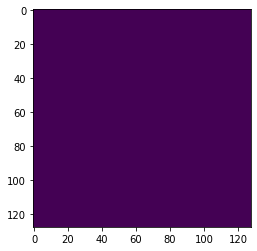

In [ ]:
plt.imshow(masks[2])

In [ ]:

ori = []
pred = []
binary = []
model.eval()
for i, data in tqdm(enumerate(test_loader)):
    x = data[0].cuda()
    y = np.transpose(data[1].cpu().detach().numpy(), (0, 2, 3, 1))
    p1 = model(x)
    p1 = torch.sigmoid(p1)
    p1 = np.transpose((p1.cpu().detach().numpy() > 0.5),(0, 2, 3, 1))

    # p2 = torch.sigmoid(p2)
    # p2 = np.transpose((p2.cpu().detach().numpy()),(0, 2, 3, 1))


    ori.append(y.astype('int8'))
    pred.append(p1.astype('uint8'))
    # binary.append(p2[0][:,:,0].astype('float32'))
    break

  

0it [00:00, ?it/s]


## Convert to some color map

In [ ]:
import os
import glob
import cv2

In [ ]:
color_dict = {
    0: (0, 0, 0), # background
    1:(255, 25, 122), #bricks
    2:(225, 187, 100), #pvc
    3:(89, 100, 6), # wires
    4:(0,255,255) #rebar
    5:(255,10,10)
    }

In [ ]:
def convert_to_rgb(path, color):
    img = cv2.imread(path)
    img = img/255
    img[:,:,0] = img[:,:,0]*color[0]
    img[:,:,1] = img[:,:,1]*color[1]
    img[:,:,2] = img[:,:,2]*color[2]

    return img.astype('uint8')
    
    


In [ ]:
brick_path = sorted(glob.glob('/content/drive/Shareddrives/hackathon/Training datasets only/masks/Rebar/*.jpg'))
brick_path.sort()

In [ ]:
len(brick_path)

56

In [ ]:
color_path = '/content/drive/Shareddrives/hackathon/Training datasets only/Multi_class_mask/Rebar/'

In [ ]:
for i in brick_path:
    p = i
    p = p.split('/')
    name  = p[-1]
    img = convert_to_rgb(i, color_dict[4])
    cv2.imwrite(color_path+name, img)

In [ ]:
for i, j in zip(x, y):
    pass
    